In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

parent_path = str(os.path.dirname(os.getcwd()))
reds = pd.read_csv(parent_path + "/data/winequality-red.csv", delimiter = ";")
whites = pd.read_csv(parent_path + "/data/winequality-white.csv", delimiter = ";")
# wines = pd.concat([reds, whites], axis = 0) 
#creating is_good field for binary classification
# wines['is_good'] = np.where(wines['quality'] < 7, 0, 1)
reds['is_good'] = np.where(reds['quality'] < 7, 0, 1)
whites['is_good'] = np.where(whites['quality'] < 7, 0, 1)
#dropping quality so model doesn't learn this
# wines = wines.drop('quality',1)
reds = reds.drop('quality',1)
whites = whites.drop('quality',1)
reds 
whites

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,is_good
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,0
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,0
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,1


In [3]:
#import the decision tree module from sklearn
from sklearn.tree import DecisionTreeClassifier

#build a decision tree with max_depth = 20 using entropy
Yred = reds['is_good']
Xred = reds.drop('is_good', 1)
dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 20)
dt.fit(Xred, Yred)

#Now use built in feature importance attribute to get MI of each feature and Y
feature_mi_red = dt.feature_importances_

In [4]:
Ywhite = whites['is_good']
Xwhite = whites.drop('is_good', 1)
dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 20)
dt.fit(Xwhite, Ywhite)
feature_mi_white = dt.feature_importances_

In [6]:
#Add features and their importances to a dictionary
feature_mi_dict_red = dict(zip(Xred.columns.values, feature_mi_red))
feature_mi_dict_white = dict(zip(Xwhite.columns.values, feature_mi_white))

In [7]:
#define a function to print ROC curves. 
#It should take in only arrays/lists of predictions and outcomes
from sklearn.metrics import roc_curve, auc

def plotUnivariateROC(preds, truth, label_string):
    '''
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''
    #1. call the roc_curve function to get the ROC X and Y values
    fpr, tpr, thresholds = roc_curve(truth, preds)
    #2. Input fpr and tpr into the auc function to get the AUC
    roc_auc = auc(fpr, tpr)
    
    #we are doing this as a special case because we are sending unfitted predictions
    #into the function
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)

    #chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())

    #create a plot and set some options
    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

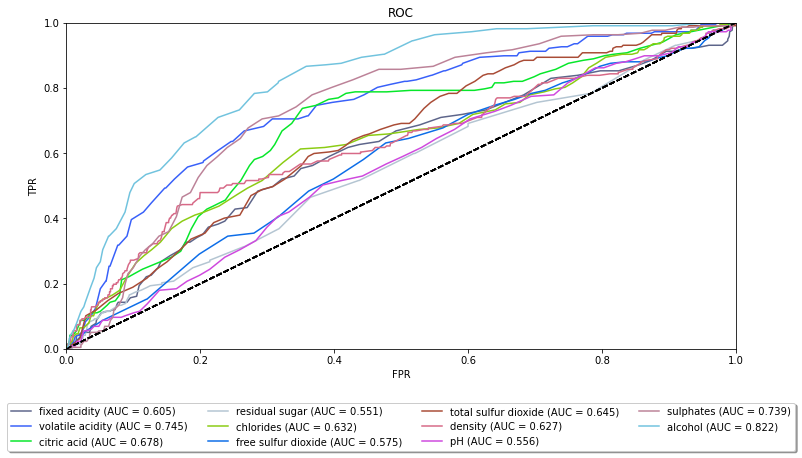

In [10]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

#Plot the univariate AUC on the training data. Store the AUC

feature_auc_dict_red = {}
for col in reds.drop('is_good',1).columns:
    feature_auc_dict_red[col] = plotUnivariateROC(reds[col], Yred, col)


# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

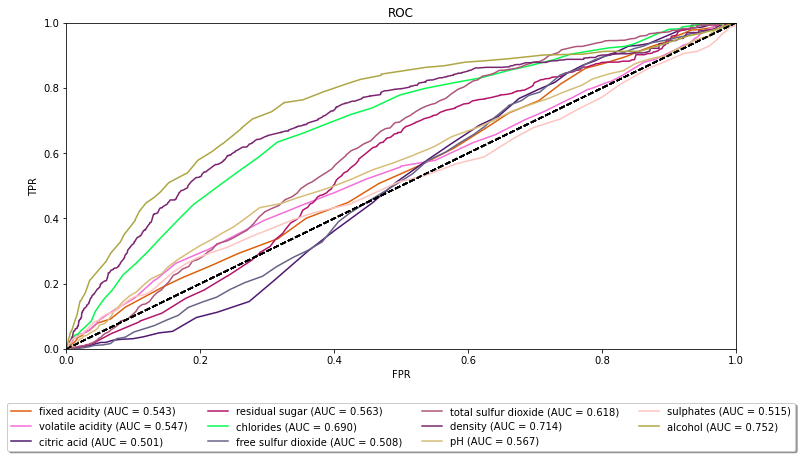

In [11]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

#Plot the univariate AUC on the training data. Store the AUC

feature_auc_dict_white = {}
for col in whites.drop('is_good',1).columns:
    feature_auc_dict_white[col] = plotUnivariateROC(whites[col], Ywhite, col)


# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

In [12]:
#Add auc and mi each to a single dataframe
df_auc_red = pd.DataFrame(pd.Series(feature_auc_dict_red), columns = ['auc'])
df_mi_red = pd.DataFrame(pd.Series(feature_mi_dict_red), columns = ['mi'])

#Now merge the two on the feature name
feat_imp_df_red = df_auc_red.merge(df_mi_red, left_index = True, right_index = True)
feat_imp_df_red

,auc,mi
fixed acidity,0.604954,0.049866
volatile acidity,0.745092,0.113927
citric acid,0.678216,0.039247
residual sugar,0.550760,0.050076
chlorides,0.632258,0.054988
free sulfur dioxide,0.575003,0.020177
total sulfur dioxide,0.644923,0.115324
density,0.627400,0.108266
pH,0.556085,0.051236
sulphates,0.738833,0.136654


In [14]:
#Add auc and mi each to a single dataframe
df_auc_white = pd.DataFrame(pd.Series(feature_auc_dict_white), columns = ['auc'])
df_mi_white = pd.DataFrame(pd.Series(feature_mi_dict_white), columns = ['mi'])

#Now merge the two on the feature name
feat_imp_df_white = df_auc_white.merge(df_mi_white, left_index = True, right_index = True)
feat_imp_df_white

,auc,mi
fixed acidity,0.542719,0.066741
volatile acidity,0.546597,0.092844
citric acid,0.500781,0.093199
residual sugar,0.562697,0.080115
chlorides,0.690441,0.049939
free sulfur dioxide,0.508142,0.080247
total sulfur dioxide,0.617750,0.081753
density,0.713980,0.072614
pH,0.566596,0.079105
sulphates,0.515299,0.079686


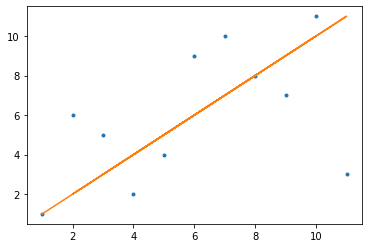

In [35]:
#Now create a df that holds the ranks of auc and mi 
feat_ranks = feat_imp_df.rank(axis = 0, ascending = False)

#Plot the two ranks
plt.plot(feat_ranks.auc, feat_ranks.mi, '.')
#Plot a y=x reference line
plt.plot(feat_ranks.auc, feat_ranks.auc,)

In [36]:
#Now create lists of top 5 features for both auc and mi
top5_auc = list(feat_ranks[(feat_ranks.auc <= 5)].index.values)
top5_mi = list(feat_ranks[(feat_ranks.mi <= 5)].index.values)
top5_auc, top5_mi

(['volatile acidity', 'citric acid', 'chlorides', 'density', 'alcohol'],
 ['volatile acidity', 'citric acid', 'chlorides', 'sulphates', 'alcohol'])

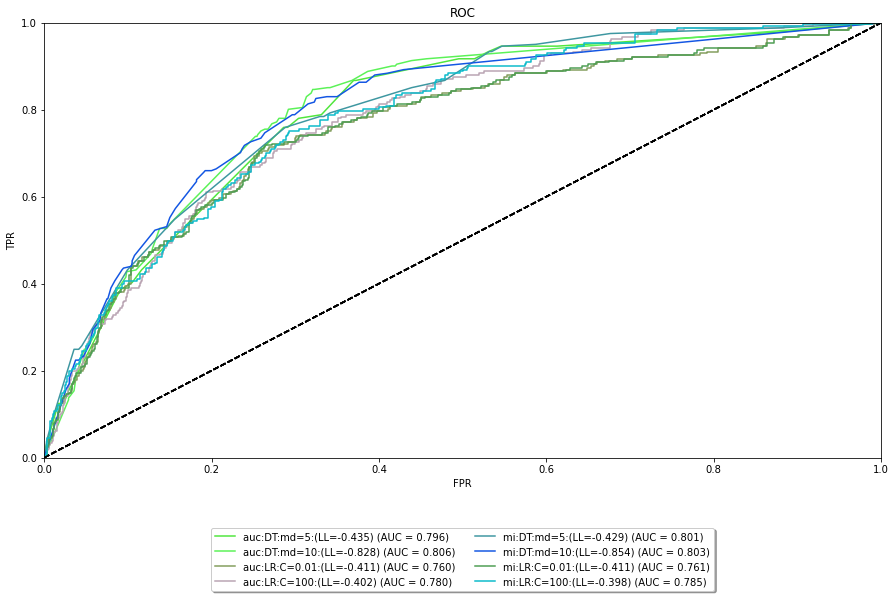

In [37]:
'''
Now do the following
1. Split the data into 80/20 train/test
2. For each set of features:
- build two decision trees (max_depth in {10, 20}) 
- build two logistic regression (C in {10**-2, 10**2})
- get the auc and log-loss on the test set
'''
from sklearn.linear_model import LogisticRegression


def getLogLoss(Ps, Ys, eps = 10**-6):
    return ((Ys == 1) * np.log(Ps + eps) + (Ys == 0) * np.log(1 - Ps + eps)).mean()

#Split into train and test randomly without using sklearn package
#Note, there are many ways to do this:

train_pct = 0.8
#1. create an array of n random uniform variables drawn on [0,1] range
rand = np.random.rand(wines.shape[0])
#2. Convert to boolean where True = random number < train_pct
rand_filt = (rand < train_pct)

#Use the filter to index data

train = wines[rand_filt]
test = wines[(rand_filt == False)]


fsets = [top5_auc, top5_mi]
fset_descr = ['auc', 'mi']
mxdepths = [5, 10]
Cs = [10**-2, 10**2]


#Set up plotting box
fig = plt.figure(figsize = (15, 8))
ax = plt.subplot(111)


for i, fset in enumerate(fsets):
    descr = fset_descr[i]
    #set training and testing data
    Y_train = train['is_good']
    X_train = train[fset]
    Y_test = test['is_good']
    X_test = test[fset]
    
    for d in mxdepths:
        dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = d)
        dt.fit(X_train, Y_train)
        preds_dt = dt.predict_proba(X_test)[:, 1]
        ll_dt = getLogLoss(preds_dt, Y_test)
        
        plotUnivariateROC(preds_dt, Y_test, '{}:DT:md={}:(LL={})'.format(descr, d, round(ll_dt, 3)))

        
    for C in Cs:
        lr = LogisticRegression(C = C)
        lr.fit(X_train, Y_train)
        preds_lr = lr.predict_proba(X_test)[:, 1]
        ll_lr = getLogLoss(preds_lr, Y_test)

        plotUnivariateROC(preds_lr, Y_test, '{}:LR:C={}:(LL={})'.format(descr, C, round(ll_lr, 3)))

    
# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 2, prop = {'size':10})

**Alcohol seems to produce the best model. Intuitively, in terms of flavor, the percentage of alochol that a wine has can really alter how it tastes. We should look further into using explaination techniques like LIME or SHAP to explain why properties lead to a particular wine earning a high quality (re: Brian's email).**